# Pull new images from xView into ShipRS

### Preprocessing: compare and contrast the xView and ShipRS Dataset

xView is a *superset* of ShipRS--all ShipRS images containing fishing vessel(s) came from xView, but not all fishing vessel xView images are already in ShipRS. ShipRS's training set currently has 318 fishing vessel instances versus xView's training set which has 799. The purpose of the notebook is to uncover and add xView images not already in ShipRS. It's important to note that validation labels were not provided in the xView dataset limiting the number of availble images, and there's a total of 117 images / ~830 instances of the fishing vessel class in *all* ShipRS image sets.

In [158]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
from PIL import Image
import json
import pandas as pd
from pathlib import Path
from functools import partial
from multiprocessing import Pool
import xml.etree.ElementTree as ET
import math

Process each entry in ShipRS's fishing_vessel_images.txt which was populated in `dataset_exploraton.ipynb`

In [2]:
# Extract each image"s "prefix"
# For example,  18__2164_920.bmp --> 18
#               1459__2760_920.bmp --> 1459 
shipRSPrefixes = set()
shipRSImages = {} # Key = image prefix | Value = a list of image paths containing this prefix

with open("fishing_vessel_shiprs.txt", "r") as f:
    lines = f.readlines()

for line in lines:
    # Extracts the sequence of numbers that come before the first "__"
    prefix = line.split("__")[0]
    
    # Keep track of the unique prefixes
    shipRSPrefixes.add(prefix)

    # Keep track of the images associated with each prefix
    if prefix not in shipRSImages:
        # First time encountering prefix
        shipRSImages[prefix] = [line[:-1]] # Remove the trailing new line character
    else:
        shipRSImages[prefix].append(line[:-1])
    
print(shipRSPrefixes)
print(shipRSImages)

{'1465', '1311', '1848', '1459', '1441', '1442', '1158', '1821', '1208', '1397', '2505', '1858', '2010', '2293', '1454', '1920', '1280', '1378', '2278', '1443', '1855', '1149', '126', '1351', '1918', '2562', '2555', '144', '1856', '1926', '1357', '1212', '2270', '2560', '2564', '2460', '1930', '1931', '18', '1829', '1820', '1217', '2268', '1447', '513', '2574', '1472', '1907', '1438', '1418', '1374', '2545', '1456', '1416', '1450', '107'}
{'1821': ['1821__2012_1840.bmp', '1821__1840_1840.bmp'], '2562': ['2562__1840_1840.bmp', '2562__0_1840.bmp', '2562__3207_2345.bmp', '2562__0_2345.bmp', '2562__2760_2345.bmp'], '2545': ['2545__3205_920.bmp', '2545__1840_0.bmp', '2545__1840_920.bmp', '2545__920_0.bmp', '2545__920_920.bmp', '2545__2760_920.bmp'], '1149': ['1149__1840_0.bmp', '1149__1840_1797.bmp'], '2574': ['2574__2760_0.bmp'], '107': ['107__1840_0.bmp'], '126': ['126__1840_0.bmp'], '2560': ['2560__0_920.bmp', '2560__920_1840.bmp', '2560__920_920.bmp', '2560__0_1840.bmp'], '1907': ['1907

Process each entry in xView's fishing_vessel_images.txt

In [3]:
xViewPrefixes = set()

with open("fishing_vessel_xview.txt", "r") as f:
    lines = f.readlines()

for line in lines:
    # Remove extension (.tif) in order to correctly extract the prefix
    xViewPrefixes.add(line[:-5])

print(xViewPrefixes)

{'1442', '2505', '1454', '1378', '1149', '126', '1918', '2555', '1926', '1357', '2560', '1930', '1931', '1940', '2571', '107', '1465', '2599', '1848', '1633', '1630', '1208', '1858', '2128', '2278', '1351', '2562', '31', '1212', '2270', '2564', '2268', '1906', '513', '1374', '1456', '1284', '1459', '1441', '1397', '1656', '2293', '2009', '1443', '1654', '1919', '1856', '2207', '2279', '1829', '1820', '2547', '128', '1472', '2574', '1907', '1418', '1438', '1416', '2008', '1450', '1311', '1824', '927', '1158', '1821', '2010', '1920', '1280', '1938', '1855', '144', '509', '1849', '2460', '1150', '18', '1831', '1217', '1447', '2545'}


Figure out which images are contained in xView but not in ShipRS

In [4]:
difference = xViewPrefixes.difference(shipRSPrefixes)
print(difference)

{'2599', '1824', '1633', '927', '1630', '1656', '2128', '2009', '1938', '1654', '1919', '31', '509', '1849', '2207', '2279', '1150', '1831', '1906', '2547', '128', '1940', '2571', '2008', '1284'}


Find out which images are contained in both xView and ShipRS

In [5]:
intersection = xViewPrefixes.intersection(shipRSPrefixes)
print(intersection)

{'1465', '1848', '1459', '1441', '1442', '1158', '1821', '1208', '1397', '2505', '1858', '2010', '2293', '1454', '1920', '1280', '1378', '2278', '1443', '1855', '1149', '126', '1351', '1918', '2562', '2555', '144', '1856', '1926', '1357', '1212', '2270', '2560', '2564', '2460', '1930', '1931', '18', '1829', '1820', '1217', '2268', '1447', '513', '2574', '1472', '1907', '1438', '1418', '1374', '2545', '1456', '1450', '1416', '1311', '107'}


For each image that's shared between xView and ShipRS, show them side-by-side so that they can be verified

In [6]:
def pad_images(img1, img2):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    max_height = max(h1, h2)
    max_width = w1 + w2  # Combined width

    # Create new images with padding
    img1_padded = np.zeros((max_height, max_width, 3), dtype=np.uint8)
    img2_padded = np.zeros((max_height, max_width, 3), dtype=np.uint8)

    img1_padded[:h1, :w1] = img1
    img2_padded[:h2, w1:w1+w2] = img2

    return img1_padded, img2_padded

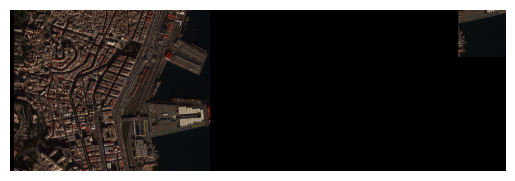

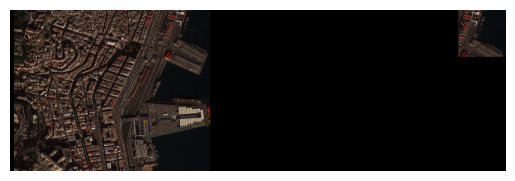

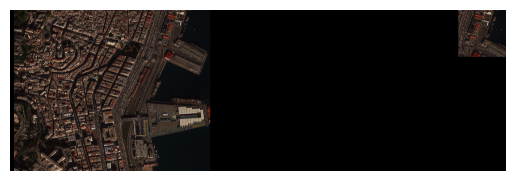

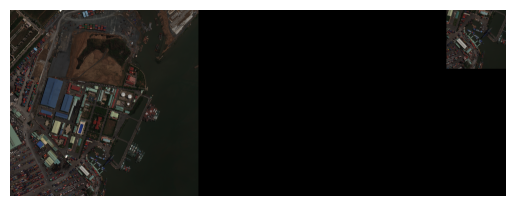

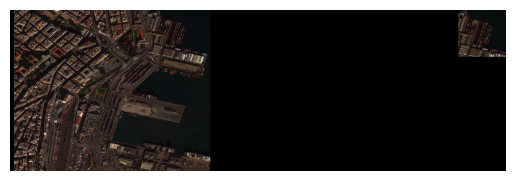

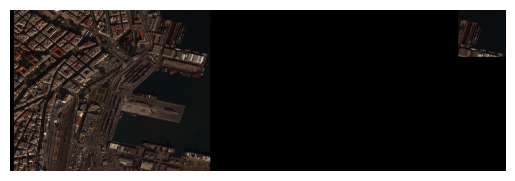

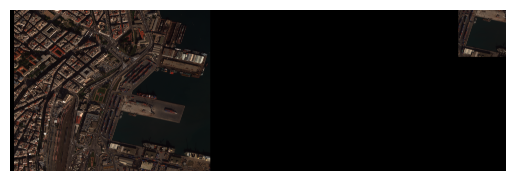

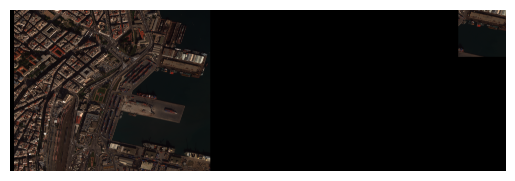

In [7]:
for prefix in list(intersection)[:3]:
    xView_image_path = os.path.join("xView", "train_images", f"{prefix}.tif")
    xView_image = cv2.imread(xView_image_path)

    for image in shipRSImages[prefix]:
        shipRS_image_path = os.path.join("ShipRSImageNet_V1", "VOC_Format", "JPEGImages", image)
        shipRS_image = cv2.imread(shipRS_image_path)

        xView_image_padded, shipRS_image_padded = pad_images(xView_image, shipRS_image)

        combined_image = np.hstack((xView_image_padded, shipRS_image_padded))

        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

As you can see, the ShipRS images on the right are cropped versions of the xView images on the left

### Now: attempt to incorporate new images into ShipRS

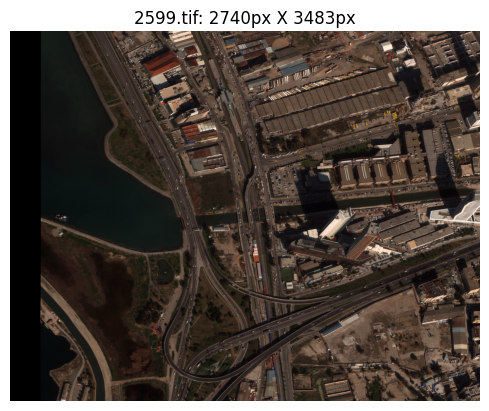

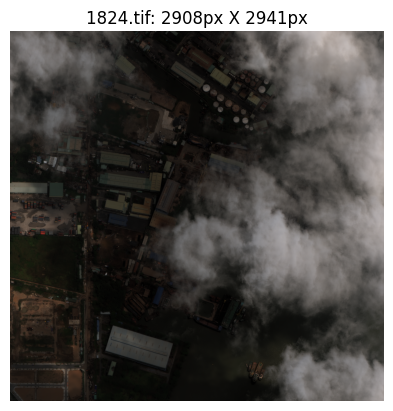

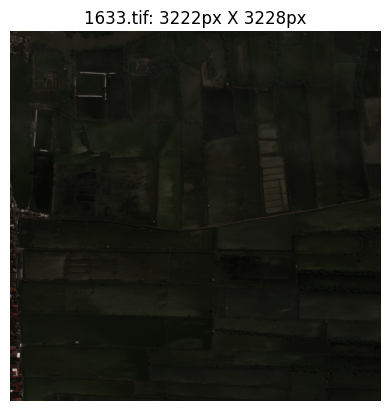

In [54]:
for image in list(difference)[:3]:
    path = os.path.join("xView", "train_images", f"{image}.tif")
    img = mpimg.imread(path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"{image}.tif: {img.shape[0]}px X {img.shape[1]}px")
    plt.axis("off")
    plt.show()
    plt.close()

The images are quite large which would be difficult for a computer vision model to process and requires a large amount of GPU memory. According to ShipRS authors: "Since the image in xView is huge for training, we slice them into 930×930 pixels with 150 pixels overlap." Let's follow this cropping procedure with images in `difference`.

In [58]:
def load_annotations_as_df(annotations):
    with open(annotations, "r") as f:
        xview = json.load(f)

    features = xview["features"]

    # Define columns
    filenames, databases, sources, resolutions, widths, heights, depths, xmins, ymins, xmaxs, ymaxs, classids = [], [], [], [], [], [], [], [], [], [], [], []

    for feature in features:
        properties = feature["properties"]
        filename = properties["image_id"]

        if filename[:-4] in difference:
            # Only add images of interest to the Dataframe
            bbox = properties["bounds_imcoords"]
            classid = properties["type_id"]

            bbox_coords = list(map(int, bbox.split(",")))
            xmin, ymin, xmax, ymax = bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3]

            filenames.append(filename)
            databases.append("WorldView 3")
            sources.append("xView")
            resolutions.append(0.3)
            widths.append(Image.open(os.path.join("xView", "train_images", filename)).width)
            heights.append(Image.open(os.path.join("xView", "train_images", filename)).height)
            depths.append(3)
            xmins.append(xmin)
            ymins.append(ymin)
            xmaxs.append(xmax)
            ymaxs.append(ymax)
            classids.append(classid)

    df = pd.DataFrame({
        "file_name": filenames,
        "database": databases,
        "source": sources,
        "resolution": resolutions,
        "width": widths,
        "height": heights,
        "depth": depths,
        "xmin": xmins,
        "ymin": ymins,
        "xmax": xmaxs,
        "ymax": ymaxs,
        "category_id": classids,
    })

    return df

In [56]:
data_path = Path("xView")
images_path = data_path/"train_images"
annotations_file_path = data_path/"xView_train.geojson"

In [59]:
df = load_annotations_as_df(annotations_file_path)
df.head()

file_name     database source  resolution  width  height  depth  xmin  ymin  \
0  2279.tif  WorldView 3  xView         0.3   3596    2725      3  3506   -80   
1  2279.tif  WorldView 3  xView         0.3   3596    2725      3  2654    33   
2  2279.tif  WorldView 3  xView         0.3   3596    2725      3  2637    32   
3  2279.tif  WorldView 3  xView         0.3   3596    2725      3  2700    27   
4  2279.tif  WorldView 3  xView         0.3   3596    2725      3  3179    35   

   xmax  ymax  category_id  
0  3610   338           89  
1  2665    46           18  
2  2644    45           18  
3  2714    49           73  
4  3190    80           24

In [60]:
fishing_vessel_df = df.query("category_id == 47")
fishing_vessel_df

file_name     database source  resolution  width  height  depth  xmin  \
159    2279.tif  WorldView 3  xView         0.3   3596    2725      3  2969   
346    2547.tif  WorldView 3  xView         0.3   4135    3275      3   313   
864    2128.tif  WorldView 3  xView         0.3   3085    2810      3  2832   
1898   2599.tif  WorldView 3  xView         0.3   3483    2740      3   246   
5222   2008.tif  WorldView 3  xView         0.3   4986    3181      3  4840   
...         ...          ...    ...         ...    ...     ...    ...   ...   
32173   128.tif  WorldView 3  xView         0.3   3093    2606      3  3007   
32174   128.tif  WorldView 3  xView         0.3   3093    2606      3  2994   
32175   128.tif  WorldView 3  xView         0.3   3093    2606      3  3023   
32176   128.tif  WorldView 3  xView         0.3   3093    2606      3  3043   
32190   128.tif  WorldView 3  xView         0.3   3093    2606      3   993   

       ymin  xmax  ymax  category_id  
159    1408  2997  1425           47  
346     704   387   915           47  
864      99  2846   128           47  
1898   2161   297  2209           47  
5222   1383  4957  1408           47  
...     ...   ...   ...          ...  
32173   382  3030   405           47  
32174   391  3013   413           47  
32175   379  3042   398           47  
32176   367  3061   385           47  
32190   772  1004   783           47  

[445 rows x 12 columns]

In [61]:
len(fishing_vessel_df.file_name.unique())

25

Within the difference set, we have 445 instances of the fishing vessel class and 25 images. Now, let's create a Dataset Wrapper.

In [62]:
def get_rectangle_params_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_bboxes(
    plot_ax,
    bboxes,
    class_labels,
    get_rectangle_corners_fn=get_rectangle_params_from_pascal_bbox,
):
    for bbox, label in zip(bboxes, class_labels):
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left, width, height, linewidth=4, edgecolor="black", fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left, width, height, linewidth=2, edgecolor="white", fill=False,
        )
        rx, ry = rect_1.get_xy()

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)
        plot_ax.annotate(label, (rx+width, ry+height), color='white', fontsize=10)

def show_image(image, bboxes=None, class_labels=None, draw_bboxes_fn=draw_bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    if bboxes:
        draw_bboxes_fn(ax, bboxes, class_labels)
        
    plt.show()

In [63]:
class DatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.file_name_to_idx = {
            image_id: idx
            for idx, image_id in enumerate(self.annotations_df.file_name.unique())
        }
        self.idx_to_file_name = {v: k for k, v, in self.file_name_to_idx.items()}

    def __len__(self) -> int:
        return len(self.file_name_to_idx)

    def __getitem__(self, index):
        file_name = self.idx_to_file_name[index]
        image = Image.open(self.images_dir_path / file_name)
        
        # Retrieves all of the image's bounding boxes and annotations
        xyxy_bboxes = self.annotations_df.query("file_name == @file_name")[
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = self.annotations_df.query("file_name == @file_name")[
            "category_id"
        ].values

        return np.array(image), xyxy_bboxes, class_labels, index

In [64]:
ds = DatasetAdaptor(images_path, fishing_vessel_df)

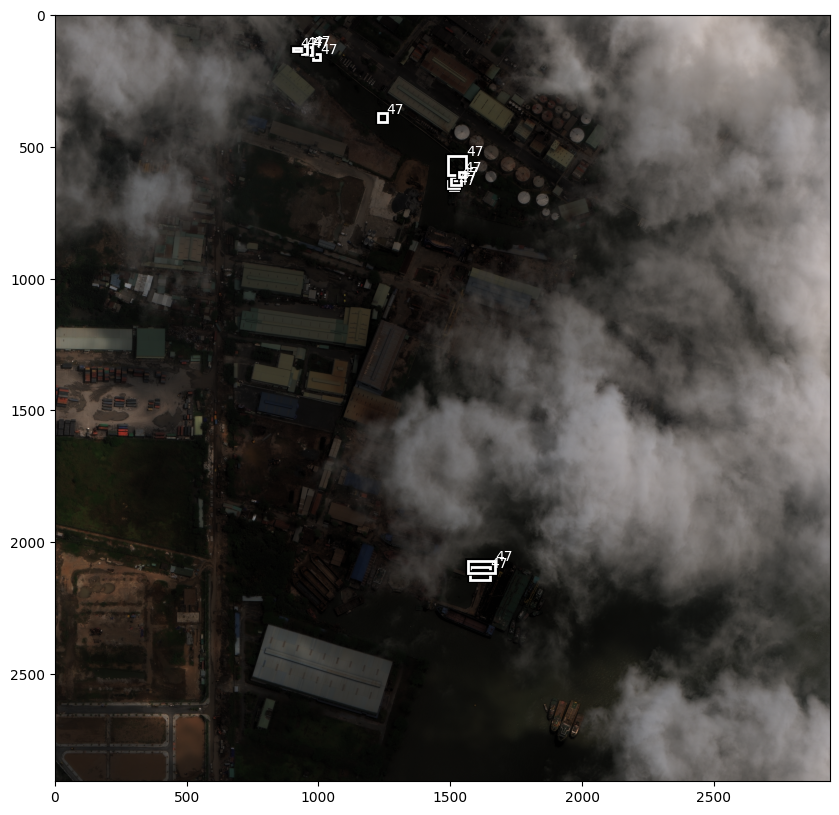

In [65]:
idx = 6
image, bboxes, class_labels, image_id = ds[idx]
show_image(image, bboxes.tolist(), class_labels.tolist())

In [17]:
ds.idx_to_file_name[6]

'1824.tif'

In the sample image, it's difficult to see the object contained in each bbox. Opening up the image using `xdg-open` verifies that the annotations are infact correct. This highlights the fine-grained / small object detection nature of this dataset and why cropping the image would comprimise the already limited image details. If you'd like to see all bboxes present in an image, run `ds = DatasetAdaptor(os.path.join("xView", "train_images"), df)` instead.

In [66]:
def calculate_slice_bboxes(
    image_height: int,
    image_width: int,
    slice_height: int = 930,
    slice_width: int = 930,
    overlap_height: int = 150,
    overlap_width: int = 150,
):
    """
    Given the height and width of an image, calculates how to divide the image into
    overlapping slices according to the height and width provided. These slices are returned
    as bounding boxes in xyxy format.

    :param image_height: Height of the original image.
    :param image_width: Width of the original image.
    :param slice_height: Height of each slice
    :param slice_width: Width of each slice
    :param overlap_height_ratio: Fractional overlap in height of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :param overlap_width_ratio: Fractional overlap in width of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :return: a list of bounding boxes in xyxy format
    """

    slice_bboxes = []
    y_max = y_min = 0
    y_overlap = overlap_height # int(overlap_height_ratio * slice_height)
    x_overlap = overlap_width # int(overlap_width_ratio * slice_width)
    while y_max < image_height:
        x_min = x_max = 0
        y_max = y_min + slice_height
        while x_max < image_width:
            x_max = x_min + slice_width
            if y_max > image_height or x_max > image_width:
                xmax = min(image_width, x_max)
                ymax = min(image_height, y_max)
                xmin = max(0, xmax - slice_width)
                ymin = max(0, ymax - slice_height)
                slice_bboxes.append([xmin, ymin, xmax, ymax])
            else:
                slice_bboxes.append([x_min, y_min, x_max, y_max])
            x_min = x_max - x_overlap
        y_min = y_max - y_overlap
    return slice_bboxes

Test the slicing code on ds[6]

In [19]:
slices = calculate_slice_bboxes(image_height=image.shape[0], image_width=image.shape[1])

In [67]:
slices

[[0, 0, 930, 930],
 [780, 0, 1710, 930],
 [1560, 0, 2490, 930],
 [2011, 0, 2941, 930],
 [0, 780, 930, 1710],
 [780, 780, 1710, 1710],
 [1560, 780, 2490, 1710],
 [2011, 780, 2941, 1710],
 [0, 1560, 930, 2490],
 [780, 1560, 1710, 2490],
 [1560, 1560, 2490, 2490],
 [2011, 1560, 2941, 2490],
 [0, 1978, 930, 2908],
 [780, 1978, 1710, 2908],
 [1560, 1978, 2490, 2908],
 [2011, 1978, 2941, 2908]]

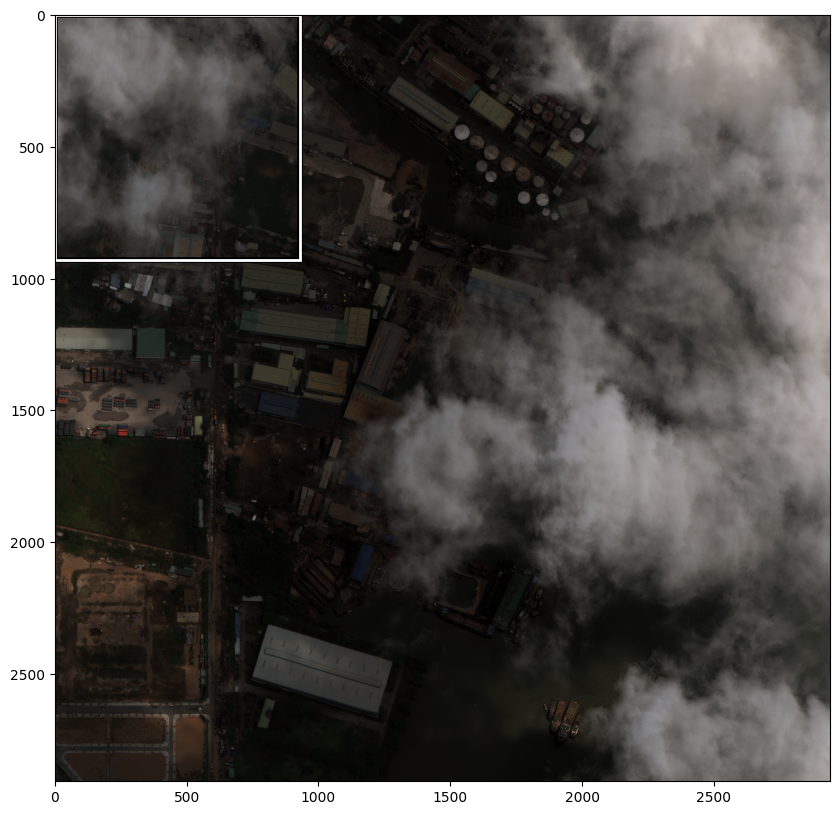

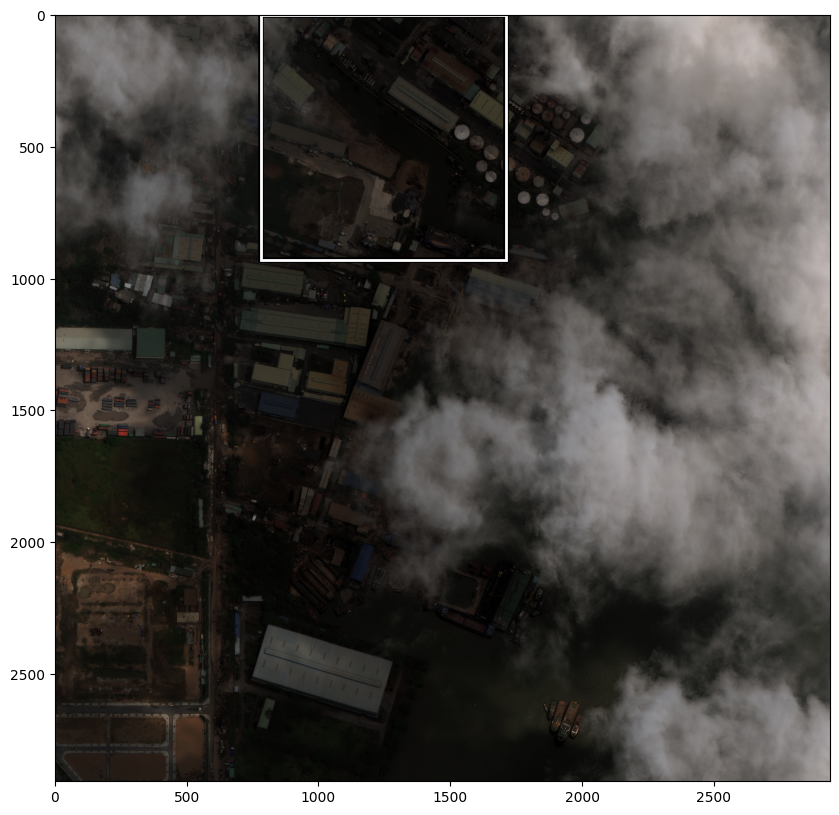

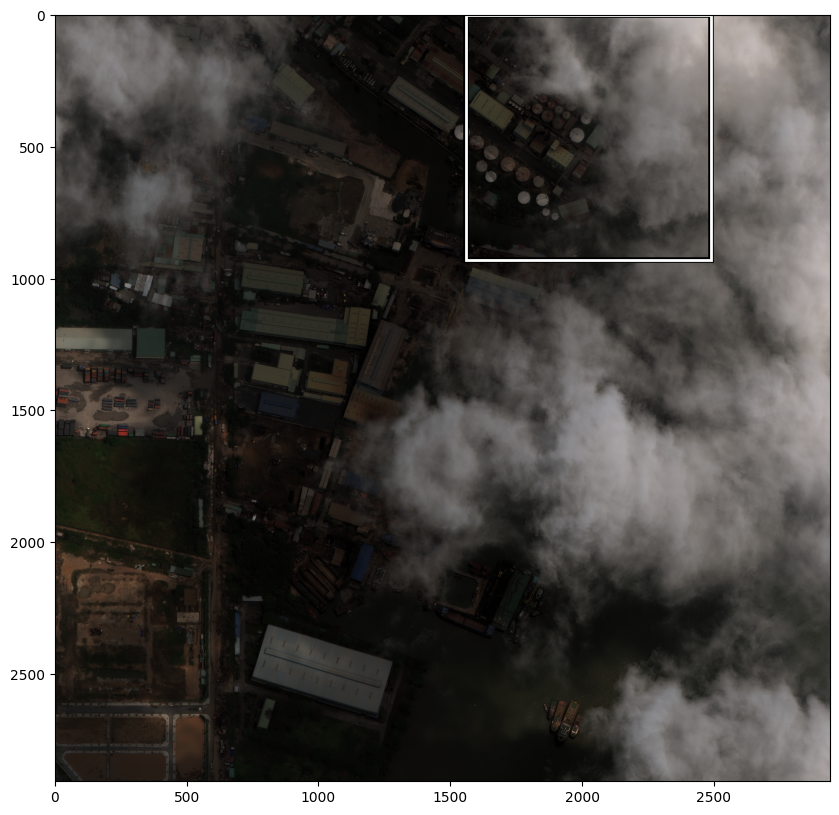

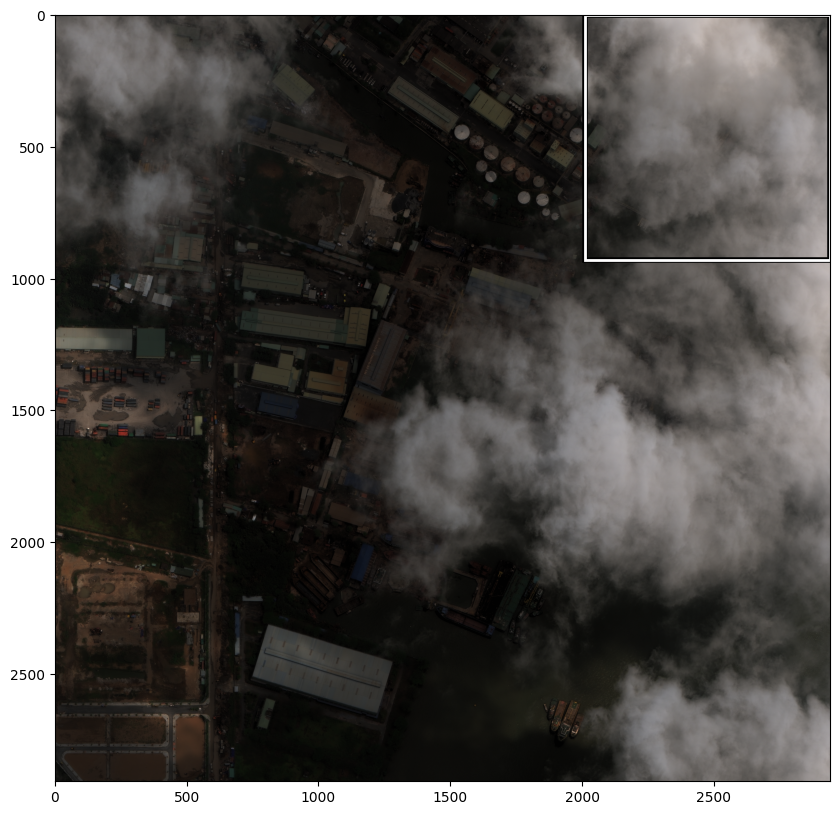

In [68]:
for slice_bbox in slices[:4]:
    # Essentially displaying the slice as an unlabeled bounding box
    show_image(image, [slice_bbox], [''])

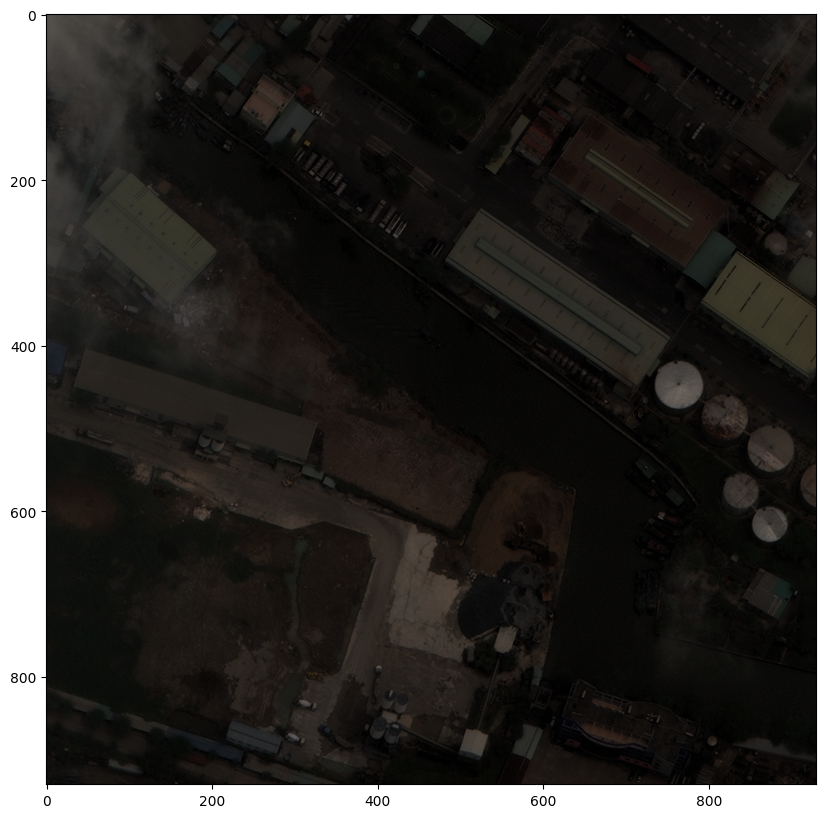

In [69]:
slice_index = 1
xmin, ymin, xmax, ymax = slices[slice_index]
# Recall that image is returned as numpy array
show_image(image[ymin:ymax, xmin:xmax,])

As we are slicing our image into smaller patches, we will also have to modify our bounding box annotations in two ways:

- for each slice, we need to determine which bounding boxes are contained in this slice
- for the bounding boxes present, we need to scale the boxes so that they are relative to the containing slice.

Albumentations library contains this functionality as part of its Crop transform.


In [70]:
import albumentations as A

In [71]:
crop_transform = A.Compose(
        [A.Crop(*slices[slice_index]),],
        bbox_params=A.BboxParams(format="pascal_voc",
                                 label_fields=['labels'],
                                 min_visibility=0.1,
                                 min_area=0.1),
    )

In [72]:
transformed = crop_transform(image=image, bboxes=bboxes, labels=class_labels)

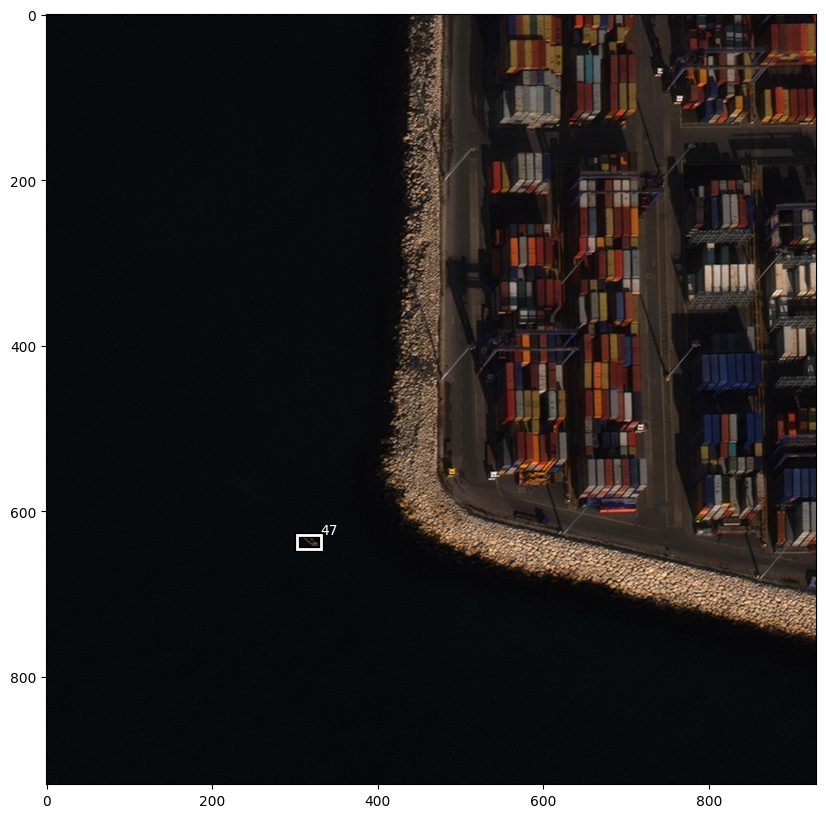

In [170]:
show_image(transformed['image'], transformed['bboxes'], transformed['labels'])

As we slice images in our dataset, it's important to gather information about each image's size because it's a parameter to `calculate_slice_bboxes`

In [74]:
def get_image_sizes_df(images_path, file_names):
    pool = Pool(processes=len(os.sched_getaffinity(0)))
    image_sizes = pool.map(partial(get_image_size, images_path=images_path), file_names)
    sizes_df = pd.DataFrame(image_sizes)
    return sizes_df

def get_image_size(file_name, images_path):
    image = Image.open(images_path / file_name)
    w, h = image.size
    return {"file_name": file_name, "image_height": h, "image_width": w}

It'd also be useful to know which image slices contains instance(s) of the fishing vessel class

In [96]:
def contains_object(
    annotations_df, image_slice_row, min_bbox_visibility=0.1, min_bbox_area=0.1
):
    # Extract bounding box coordinates of the image corresponding to image_slice_row
    xyxy_bboxes = annotations_df.query("file_name == @image_slice_row.file_name")[
        ["xmin", "ymin", "xmax", "ymax"]
    ].values

    # Correct for any out of range bbox annotations
    xyxy_bboxes[:, 0] = xyxy_bboxes[:, 0].clip(min=0) # xmin has lower bound of 0
    xyxy_bboxes[:, 1] = xyxy_bboxes[:, 1].clip(min=0) # ymin has lower bound of 0
    xyxy_bboxes[:, 2] = xyxy_bboxes[:, 2].clip(max=image_slice_row["image_width"]) # xmax has upper bound of image width
    xyxy_bboxes[:, 3] = xyxy_bboxes[:, 3].clip(max=image_slice_row["image_height"]) # ymax has upper bound of image height

    # Extract image slice coordinates
    slice_bbox = image_slice_row[["xmin", "ymin", "xmax", "ymax"]].values
    
    # Define an Albumentations transformation pipeline where the image is
    # cropped to the region defined by slice_bbox and bounding box transformations are also handled 
    transforms = A.Compose(
        [A.Crop(*slice_bbox)],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            min_visibility=min_bbox_visibility,
            min_area=min_bbox_area,
            label_fields=["labels"],
        ),
    )
    transformed = transforms(
        # use dummy array to avoid loading image and labels
        image=np.ones((image_slice_row.image_height, image_slice_row.image_width, 3)),
        labels=np.ones(len(xyxy_bboxes)),
        bboxes=xyxy_bboxes,
    )

    # Extract the transformed bboxes
    transformed_boxes = transformed["bboxes"]

    # Return True if any bounding boxes remain in the slice after cropping and applyng
    # visibility and area filters, otherwise return False
    # Essentially returns whether any fishing vessels are present in the resulting slice
    return len(transformed_boxes) > 0

In [97]:
def create_image_slices_df(
    images_path,
    fishing_vessel_df,
    slice_height: int = 930,
    slice_width: int = 930,
    overlap_height: int = 150,
    overlap_width: int = 150,
    min_bbox_area: float = 0.1,
    min_bbox_visibility: float = 0.1,
):
    # Return a dataframe associating each distinct image in fishing_vessel_df with its image size
    # | file_name	    image_height	image_width |
    # | 2279.tif	    2725	        3596        |
    sizes_df = get_image_sizes_df(images_path, fishing_vessel_df.file_name.unique())
    
    # Create a column called slices where for each row the slice coordinates will be returned
    # | file_name	image_height	image_width	    slices                        |
    # | 2279.tif	2725	        3596	        [[0, 0, 930, 930], [780,...   |
    sizes_df["slices"] = sizes_df.apply(
        lambda row: calculate_slice_bboxes(
            row.image_height,
            row.image_width,
            slice_height,
            slice_width,
            overlap_height,
            overlap_width,
        ),
        axis=1,
    )

    # Create a row for each slice and for each slice label slice[0] as xmin slice[1] as ymin...
    slices_row_df = (
        sizes_df[["file_name", "slices"]]
        .explode("slices")
        .rename(columns={"slices": "slice"})
    )
    slices_row_df = pd.DataFrame(
        slices_row_df.slice.tolist(),
        columns=["xmin", "ymin", "xmax", "ymax"],
        index=slices_row_df.file_name,
    ).reset_index()

    image_slices_df = pd.merge(
        slices_row_df,
        sizes_df[["file_name", "image_height", "image_width"]],
        how="inner",
        on="file_name",
    )
    
    # Create a column that specifies if a slice contains a fishing vessel 
    image_slices_df["contains_object"] = image_slices_df.apply(
        partial(
            contains_object,
            fishing_vessel_df,
            min_bbox_area=min_bbox_area,
            min_bbox_visibility=min_bbox_visibility,
        ),
        axis=1,
    )
    image_slices_df.reset_index(inplace=True)
    image_slices_df.rename(columns={"index": "slice_id"}, inplace=True)

    return image_slices_df

In [98]:
image_slices_df = create_image_slices_df(images_path, fishing_vessel_df)
image_slices_df.head()

slice_id file_name  xmin  ymin  xmax  ymax  image_height  image_width  \
0         0  2279.tif     0     0   930   930          2725         3596   
1         1  2279.tif   780     0  1710   930          2725         3596   
2         2  2279.tif  1560     0  2490   930          2725         3596   
3         3  2279.tif  2340     0  3270   930          2725         3596   
4         4  2279.tif  2666     0  3596   930          2725         3596   

   contains_object  
0            False  
1            False  
2            False  
3            False  
4            False

In [137]:
fishing_vessel_slices = image_slices_df.query("contains_object == True")
print(fishing_vessel_slices.shape[0])
fishing_vessel_slices.head()

58


slice_id file_name  xmin  ymin  xmax  ymax  image_height  image_width  \
8          8  2279.tif  2340   780  3270  1710          2725         3596   
9          9  2279.tif  2666   780  3596  1710          2725         3596   
20        20  2547.tif     0     0   930   930          3275         4135   
26        26  2547.tif     0   780   930  1710          3275         4135   
53        53  2128.tif  2155     0  3085   930          2810         3085   

    contains_object  
8              True  
9              True  
20             True  
26             True  
53             True

After parsing through all 58 image slices I determined:
- good augmentation canidates because the vessels were in open sea
- images that may be thrown out either because the fishing vessel was overly truncated or because another image slice existed that looked too similar
- images that can be used
- truncated images (an annotation element!)
- images with fog (another annotation element!)

Due to the 150 pixel overlap used during slicing, there were several images that contained the same fishing vessel. Despite this duplication, I chose to keep all images featuring the same fishing vessel if its **position** in the image was varied enough. After all, you'll find augmentation techniques that transpose (rotate, flip) images so I thought this choice was appropriate.

In [130]:
keep = {8, 9, 20, 53, 76, 81, 99, 121, 122, 131, 142, 143, 151, 152, 155, 156, 162, 163, 164, 176, 177, 178, 179, 182, 183, 198, 207, 239, 242, 271, 276, 280, 281, 286, 290, 297, 310, 341, 350, 354, 355, 356, 358, 378, 381, 398, 406, 410, 424, 443, 445, 447}
fishing_vessel_slices_final = pd.DataFrame()

fishing_vessel_slices_final = pd.concat(
    [fishing_vessel_slices_final, fishing_vessel_slices.loc[fishing_vessel_slices.index.isin(keep)]],
    axis=0
).reset_index(drop=True)

In [134]:
fishing_vessel_slices_final.head()

slice_id file_name  xmin  ymin  xmax  ymax  image_height  image_width  \
0         8  2279.tif  2340   780  3270  1710          2725         3596   
1         9  2279.tif  2666   780  3596  1710          2725         3596   
2        20  2547.tif     0     0   930   930          3275         4135   
3        53  2128.tif  2155     0  3085   930          2810         3085   
4        76  2599.tif     0  1560   930  2490          2740         3483   

   contains_object  
0             True  
1             True  
2             True  
3             True  
4             True

Download these 52 images and their annotations in `tmp_images` folder which will be an intermediary spot before they're fully integrated into ShipRSImageNet

In [173]:
image_output_dir = Path("tmp_images")
xml_output_dir = Path("tmp_xml")

In [174]:
for loc, row in fishing_vessel_slices_final.iterrows():
    file_name = row["file_name"]
    
    # Download image to a temp folder
    image = Image.open(images_path / file_name)  
    image_slice = Image.fromarray(np.array(image)[ymin:ymax, xmin:xmax,])
    image_slice.save(image_output_dir / f'{file_name[:-4]}__{row["slice_id"]}.bmp')

Now, let's extract information used for image annotations

In [175]:
truncated = {142, 297, 310, 341, 350, 354, 447}
fog = {142, 143, 151, 152, 155, 156, 198, 381, 398}
# These images' locations are at sea which makes them good augmentation candidates
# all other images are either on land, nearland, near a dock etc.
sea = {20, 443}

In [189]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

def prettify(elem):
    """Return a pretty-printed XML string for the Element."""
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="    ")

def write_annotation(filename, index, objects, output_dir):
    annotation = ET.Element('annotation')
    
    annotator = ET.SubElement(annotation, 'annotator')
    annotator.text = "zhang zhengning"
    
    source = ET.SubElement(annotation, 'source')
    database = ET.SubElement(source, 'database')
    database.text = "WorldView 3"
    dataset_source = ET.SubElement(source, 'dataset_source')
    dataset_source.text = "xView"

    # Empty tag; xView images don't have an associated port id
    port_id = ET.SubElement(annotation, 'port_id')

    img_resolution = ET.SubElement(annotation, 'Img_Resolution')
    img_resolution.text = "0.3"

    folder_elem = ET.SubElement(annotation, 'folder')
    folder_elem.text = "images"

    filename_elem = ET.SubElement(annotation, 'filename')
    filename_elem.text = f'{filename[:-4]}__{index}.xml'

    # All xView images have been sliced to have an image width and height of 930x930
    size = ET.SubElement(annotation, 'size')
    width_elem = ET.SubElement(size, 'width')
    width_elem.text = "930"
    height_elem = ET.SubElement(size, 'height')
    height_elem.text = "930"
    depth_elem = ET.SubElement(size, 'depth')
    depth_elem.text = "3"

    for obj in objects:
        obj_elem = ET.SubElement(annotation, 'object')
        
        name = ET.SubElement(obj_elem, 'name')
        name.text = "Fishing Vessel"
        
        level_0 = ET.SubElement(obj_elem, 'level_0')
        level_0.text = "1"
        
        level_1 = ET.SubElement(obj_elem, 'level_1')
        level_1.text = "3"
        
        level_2 = ET.SubElement(obj_elem, 'level_2')
        level_2.text = "21"
        
        level_3 = ET.SubElement(obj_elem, 'level_3')
        level_3.text = "46"
        
        # Empty tag; couldn't find any information online explaining what this value is
        iscrowd = ET.SubElement(obj_elem, 'iscrowd')
        
        # If a ship object is only partially visible in the image then set to 1
        truncted = ET.SubElement(obj_elem, 'truncted')
        truncted.text = obj['truncted']

        # Empty tag; couldn't find any information online explaining what this value is
        isclosed = ET.SubElement(obj_elem, 'is_closed')
        
        ship_size = ET.SubElement(obj_elem, 'Ship_size')
        ship_size.text = obj['Ship_size']
        
        ship_location = ET.SubElement(obj_elem, 'Ship_location')
        ship_location.text = obj['Ship_location']
        
        ship_env = ET.SubElement(obj_elem, 'Ship_env')
        ship_env_is_normal = ET.SubElement(ship_env, 'Ship_env_is_normal')
        ship_env_is_normal.text = obj['Ship_env_is_normal']
        ship_env_is_fog = ET.SubElement(ship_env, 'Ship_env_is_fog')
        ship_env_is_fog.text = obj['Ship_env_is_fog']
        ship_env_is_glint = ET.SubElement(ship_env, 'Ship_env_is_glint')
        ship_env_is_glint.text = obj['Ship_env_is_glint']
        ship_env_is_dark = ET.SubElement(ship_env, 'Ship_env_is_dark')
        ship_env_is_dark.text = obj['Ship_env_is_dark']
        
        ship_area = ET.SubElement(obj_elem, 'Ship_area')
        ship_area.text = obj['Ship_area']
        
        # Empty tag; couldn't find any information online explaining what this value is 
        difficult = ET.SubElement(obj_elem, 'difficult')
        
        # Empty tags below; xView images don't have rotated box and polygon annotations
        rotated_box = ET.SubElement(obj_elem, 'rotated_box')
        # cx = ET.SubElement(rotated_box, 'cx')
        # cx.text = obj['rotated_box']['cx']
        # cy = ET.SubElement(rotated_box, 'cy')
        # cy.text = obj['rotated_box']['cy']
        # width_elem = ET.SubElement(rotated_box, 'width')
        # width_elem.text = obj['rotated_box']['width']
        # height_elem = ET.SubElement(rotated_box, 'height')
        # height_elem.text = obj['rotated_box']['height']
        # rot = ET.SubElement(rotated_box, 'rot')
        # rot.text = obj['rotated_box']['rot']
        
        polygon = ET.SubElement(obj_elem, 'polygon')
        # x1 = ET.SubElement(polygon, 'x1')
        # x1.text = obj['polygon']['x1']
        # y1 = ET.SubElement(polygon, 'y1')
        # y1.text = obj['polygon']['y1']
        # x2 = ET.SubElement(polygon, 'x2')
        # x2.text = obj['polygon']['x2']
        # y2 = ET.SubElement(polygon, 'y2')
        # y2.text = obj['polygon']['y2']
        # x3 = ET.SubElement(polygon, 'x3')
        # x3.text = obj['polygon']['x3']
        # y3 = ET.SubElement(polygon, 'y3')
        # y3.text = obj['polygon']['y3']
        # x4 = ET.SubElement(polygon, 'x4')
        # x4.text = obj['polygon']['x4']
        # y4 = ET.SubElement(polygon, 'y4')
        # y4.text = obj['polygon']['y4']
        
        bndbox = ET.SubElement(obj_elem, 'bndbox')
        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = obj['bbox_xmin']
        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = obj['bbox_ymin']
        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = obj['bbox_xmax']
        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = obj['bbox_ymax']

    # Convert the annotation to a pretty-printed XML string
    xml_str = prettify(annotation)
    
    file_path = os.path.join(output_dir, f'{filename[:-4]}__{index}.xml')
    
    # Write the XML string to the file
    with open(file_path, 'w') as f:
        f.write(xml_str)

In [190]:
def create_annotations():
    for loc, row in fishing_vessel_slices_final.iterrows():
        # Extract bounding box and slice coordinates
        xyxy_bboxes = fishing_vessel_df.query("file_name == @row['file_name']")[
            ["xmin", "ymin", "xmax", "ymax"]
        ].values 
        slice_bbox = np.array([row["xmin"], row["ymin"], row["xmax"], row["ymax"]])

        # Correct for any out of range bbox annotations
        xyxy_bboxes[:, 0] = xyxy_bboxes[:, 0].clip(min=0) # xmin has lower bound of 0
        xyxy_bboxes[:, 1] = xyxy_bboxes[:, 1].clip(min=0) # ymin has lower bound of 0
        xyxy_bboxes[:, 2] = xyxy_bboxes[:, 2].clip(max=row["image_width"]) # xmax has upper bound of image width
        xyxy_bboxes[:, 3] = xyxy_bboxes[:, 3].clip(max=row["image_height"]) # ymax has upper bound of image height

        # Define an Albumentations transformation pipeline where the image is
        # cropped to the region defined by slice_bbox and bounding box transformations are also handled 
        transforms = A.Compose(
            [A.Crop(*slice_bbox)],
            bbox_params=A.BboxParams(
                format="pascal_voc",
                min_visibility=0.1,
                min_area=0.1,
                label_fields=["labels"],
            ),
        )
        # Use dummy labels so that way they don't need to be loaded
        # we already know that each bbox has label 47 (Fishing Vessel)
        transformed = transforms(
            image=np.array(Image.open(images_path / row["file_name"])),
            labels=np.ones(len(xyxy_bboxes)),
            bboxes=xyxy_bboxes,
        )

        objects = []
        for bbox in transformed["bboxes"]:
            bbox_object = {}

            bbox_object["Ship_size"] = "big"
            bbox_object["truncted"] = "1" if row["slice_id"] in truncated else "0"
            bbox_object["Ship_location"] = "sea" if row["slice_id"] in sea else "nearland"
            bbox_object["Ship_env_is_normal"] = "1" if row["slice_id"] not in fog else "0"
            bbox_object["Ship_env_is_fog"] = "1" if row["slice_id"] in fog else "0"
            bbox_object["Ship_env_is_glint"] = "0"
            bbox_object["Ship_env_is_dark"] = "0"

            # Calculate bbox's pixel area
            width = bbox[2] - bbox[0]  # xmax - xmin
            height = bbox[3] - bbox[1] # ymax - ymin
            area_px = width * height    # Area in pixels
            bbox_object["Ship_area"] = str(float(f"{math.ceil(area_px):.1f}"))
            
            # Upack tuple that holds current bounding boxes coordinates
            xmin, ymin, xmax, ymax = bbox
            bbox_object["bbox_xmin"], bbox_object["bbox_ymin"], bbox_object["bbox_xmax"], bbox_object["bbox_ymax"] = str(int(xmin)), str(int(ymin)), str(int(xmax)), str(int(ymax))

            objects.append(bbox_object)

        write_annotation(row["file_name"], row["slice_id"], objects, xml_output_dir)
        
create_annotations()